# 暗号通貨間の相関関係の分析

ビットコイン、イーサリアム、リップル、ライトコインの対米ドルの相関関係を調査した。

データは[Cryptocurrency Market Capitalizations](https://coinmarketcap.com/)のデータを使用した。

In [1]:
import requests
from datetime import datetime
import pandas as pd


def fetch_list(coin_type):
    # Cryptocurrency Market Capitalizations (https://coinmarketcap.com/) から拝借
    r = requests.get('https://graphs.coinmarketcap.com/currencies/%s/' % coin_type)
    data = r.json()
    data = data['price_usd'][0:-1]

    arr = []
    first = data[0][1]
    for d in data:
        # コインによって微妙に取得時刻が違うがそのずれは無視して、日付情報にしてしまう。
        date = datetime.fromtimestamp(int(d[0]) / 1000).date()
        value = d[1] / first
        arr.append({"date": date, "value": value})
    result = pd.DataFrame(index=[t["date"] for t in arr])
    result[coin_type] = [t["value"] for t in arr]
    return result

data_frames = []
coins = ["bitcoin", "ethereum", "ripple", "litecoin"]
for coin in coins:
    data_frames.append(fetch_list(coin))

data = pd.concat(data_frames, axis=1, join='inner')

In [2]:
data[:1].index[0]

datetime.date(2015, 8, 7)

In [3]:
data[-1:].index[0]

datetime.date(2017, 10, 25)

### 2015/8/7 からの2017/10/21の価格変化

* 全通貨、2015/8/7時点の値を1に揃えている

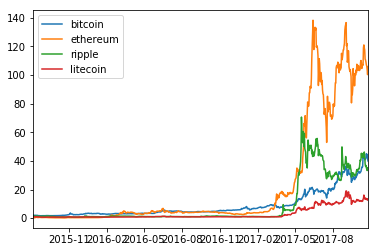

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

data.plot()

* 2017年以前が潰れてしまうので、対数化したグラフも用意した

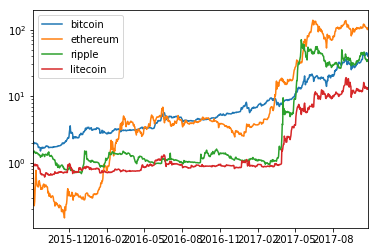

In [5]:
data.plot(logy=True)

### 全データによる相関関係

* 2015/8/7 ~ 2017/10/21(現在)

In [6]:
data.corr()

,bitcoin,ethereum,ripple,litecoin
bitcoin,1.000000,0.939119,0.843152,0.950693
ethereum,0.939119,1.000000,0.918414,0.961601
ripple,0.843152,0.918414,1.000000,0.890596
litecoin,0.950693,0.961601,0.890596,1.000000


### 1年間の相関関係

In [7]:
# 1年分 (欠損値があるためか、363になっている。)
data[-363:].corr()

,bitcoin,ethereum,ripple,litecoin
bitcoin,1.000000,0.909484,0.761533,0.932557
ethereum,0.909484,1.000000,0.878828,0.943273
ripple,0.761533,0.878828,1.000000,0.838380
litecoin,0.932557,0.943273,0.838380,1.000000


### 1ヶ月の相関関係

In [8]:
data[-31:].corr()

,bitcoin,ethereum,ripple,litecoin
bitcoin,1.000000,0.508170,0.354785,0.724769
ethereum,0.508170,1.000000,0.670053,0.751243
ripple,0.354785,0.670053,1.000000,0.296768
litecoin,0.724769,0.751243,0.296768,1.000000


### 1週間の相関関係

In [9]:
data[-7:].corr()

,bitcoin,ethereum,ripple,litecoin
bitcoin,1.000000,-0.057127,-0.559826,0.003630
ethereum,-0.057127,1.000000,0.559544,0.567703
ripple,-0.559826,0.559544,1.000000,0.788812
litecoin,0.003630,0.567703,0.788812,1.000000


図3  推定確率密度関数


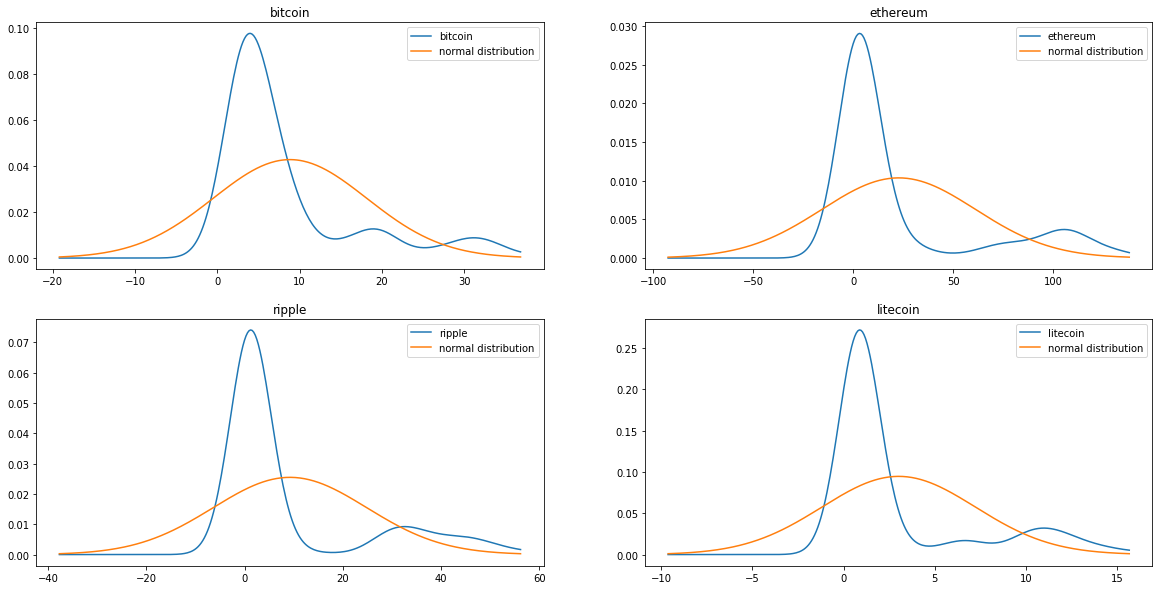

In [10]:

import scipy
from scipy.stats import gaussian_kde
import matplotlib.mlab as mlab
fig, subplts = plt.subplots(2,2,figsize=(20, 10))
stats = []
names=[]
i = 0
for name, series in data.iteritems():
    ave = series.mean()
    std = np.std(series, ddof=1)
    skew = scipy.stats.skew(series)  # 歪度
    kurtosis = scipy.stats.kurtosis(series)  # 尖度
    stats.append([ave, std, skew,kurtosis])
    ls = np.linspace(-3 * std + ave, 3 * std + ave, 300)
    norm = mlab.normpdf(ls, ave, std)
    kde = gaussian_kde(series)
    subplot = subplts[int(i/2)][i%2] 
    subplot.set_title(name)
    subplot.plot(ls, kde(ls), label=name)
    subplot.plot(ls, norm, label='normal distribution')
    subplot.legend()
    names.append(name)
    i += 1
print('図3  推定確率密度関数')

In [11]:
print('表1   各種モーメント')
pd.DataFrame(stats, index=names, columns=['平均','標準偏差','歪度','尖度'])

表1   各種モーメント


,平均,標準偏差,歪度,尖度
bitcoin,8.824570,9.330985,1.882888,2.722521
ethereum,22.824129,38.454255,1.662061,1.118623
ripple,9.243208,15.655310,1.660447,1.265850
litecoin,3.022372,4.215165,1.758127,1.756267
